In [48]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [123]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 43

In [50]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [51]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [52]:
len(dataset) #Every image is a batch of 32, hence 68

68

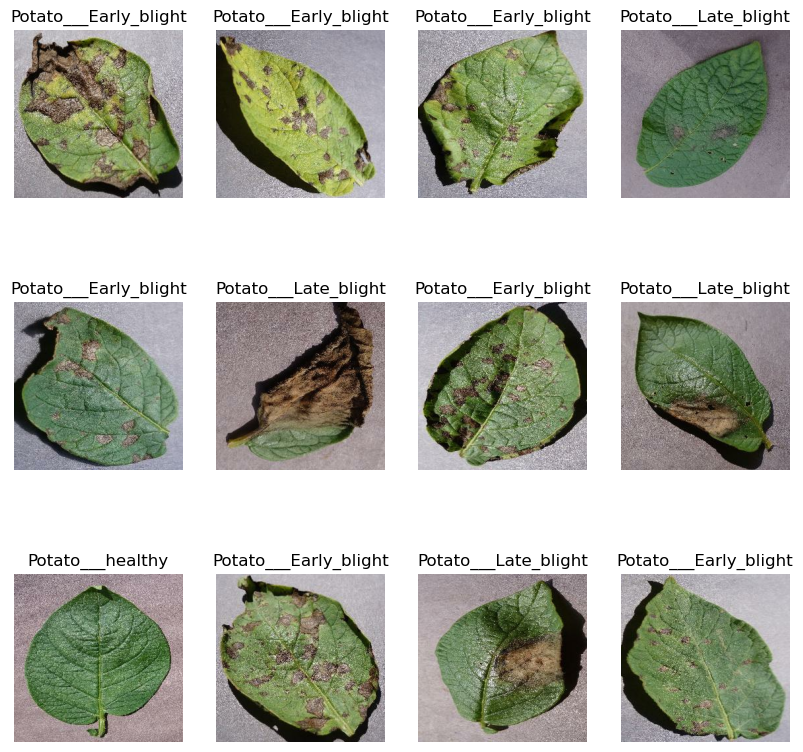

In [53]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        # print(image_batch.shape)
        # print(label_batch.numpy())
        #print(image_batch[0].numpy())

In [54]:
len(dataset)

68

In [55]:
# Let's use 80% of the data for training 
# 10% for Cross Validation
# 10% for testing

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [56]:
train_ds = dataset.take(54)
len(train_ds)

54

In [57]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [58]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [59]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [60]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [61]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split = 0.1, test_split=0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [62]:
train_ds , val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [63]:
len(train_ds)

54

In [64]:
len(val_ds)

6

In [65]:
len(test_ds)

8

In [66]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [67]:
# Scaling
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [68]:
#Data Augmentation to increase data set size for more robustness

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [69]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [70]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [125]:
history = model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 806ms/step - accuracy: 0.9737 - loss: 0.0896 - val_accuracy: 0.9844 - val_loss: 0.0476
Epoch 2/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 781ms/step - accuracy: 0.9808 - loss: 0.0528 - val_accuracy: 0.9635 - val_loss: 0.1107
Epoch 3/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 852ms/step - accuracy: 0.9849 - loss: 0.0423 - val_accuracy: 0.9792 - val_loss: 0.1611
Epoch 4/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 880ms/step - accuracy: 0.9635 - loss: 0.0855 - val_accuracy: 0.9375 - val_loss: 0.1541
Epoch 5/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 813ms/step - accuracy: 0.9854 - loss: 0.0405 - val_accuracy: 0.9740 - val_loss: 0.0811
Epoch 6/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 867ms/step - accuracy: 0.9864 - loss: 0.0383 - val_accuracy: 0.9740 - val_loss: 0.0568
Epoch 7/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 794ms/step - accuracy: 0.9721 - loss: 0.0902 - val_accuracy: 0.9896 - val_loss: 0.0689
Epoch 8/43
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 887ms/step - accuracy: 0.9880 - loss: 0.0274 - val_accu

In [186]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.9650 - loss: 0.0636


In [146]:
scores

[0.06131959706544876, 0.96875]

In [147]:
history

In [148]:
history.params

{'verbose': 1, 'epochs': 43, 'steps': 54}

In [149]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [150]:
history.history['accuracy']

[0.9803240895271301,
 0.9768518805503845,
 0.9791666865348816,
 0.9681712985038757,
 0.9820601940155029,
 0.9861111044883728,
 0.9739583134651184,
 0.9907407164573669,
 0.9837962985038757,
 0.9837962985038757,
 0.9884259104728699,
 0.9884259104728699,
 0.9809027910232544,
 0.9832175970077515,
 0.9878472089767456,
 0.9866898059844971,
 0.9820601940155029,
 0.9866898059844971,
 0.9878472089767456,
 0.9861111044883728,
 0.9861111044883728,
 0.9895833134651184,
 0.9884259104728699,
 0.9907407164573669,
 0.9971064925193787,
 0.9913194179534912,
 0.9751157164573669,
 0.9861111044883728,
 0.9814814925193787,
 0.9849537014961243,
 0.9895833134651184,
 0.9907407164573669,
 0.9884259104728699,
 0.9884259104728699,
 0.9959490895271301,
 0.9982638955116272,
 0.9930555820465088,
 0.9809027910232544,
 0.9953703880310059,
 0.9918981194496155,
 0.9878472089767456,
 0.9866898059844971,
 0.9855324029922485]

In [151]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

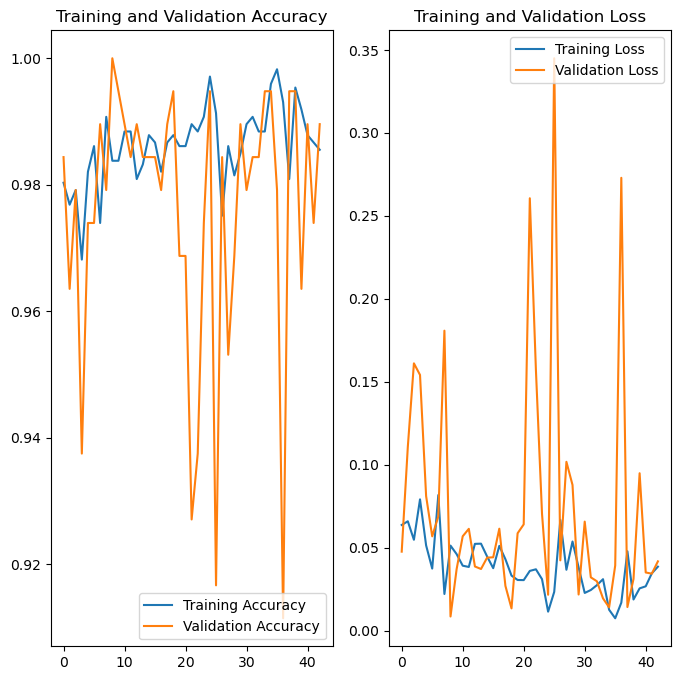

In [152]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict ; 
First image's actual label is :  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Predicted Label :  Potato___Late_blight


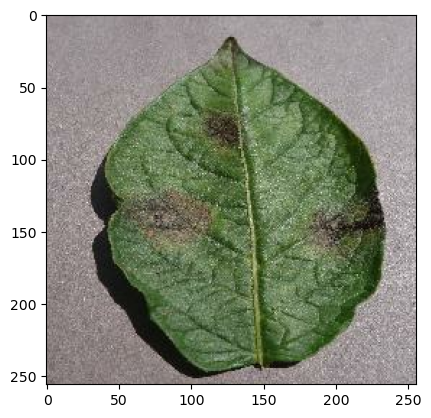

In [160]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0].numpy()

    print("First image to predict ; ")
    plt.imshow(first_image)
    print("First image's actual label is : ",class_names[first_label])

    batch_predictions = model.predict(images_batch)
    print("Predicted Label : ",class_names[np.argmax(batch_predictions[0])])


In [169]:
def predict_image(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Let's create a batch

    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2 )
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


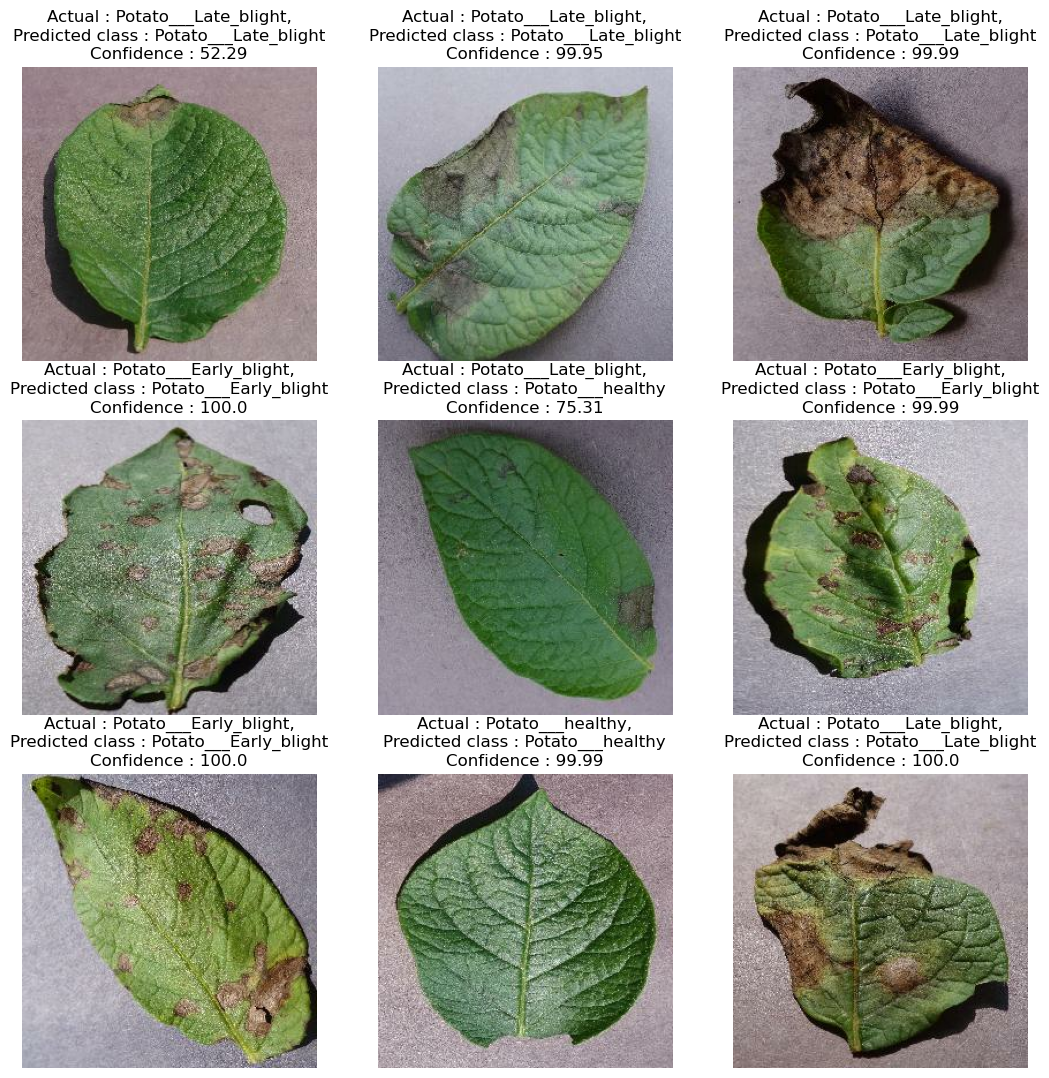

In [171]:
plt.figure(figsize = (13,13))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict_image(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class},\nPredicted class : {predicted_class}\nConfidence : {confidence}")
        
        plt.axis("off")

In [190]:
import os
path = "C:/Users/madhu/Desktop/Learning/Python - Learning/Jupyter Notebook Projects/Machine-Learning/CropCure-AI/models/"
files = os.listdir(path)
numeric_parts = [int(file.split(".")[0]) for file in files]
max_version = max(numeric_parts) if numeric_parts else 0
print(max_version)

0


In [191]:
model_version = 1+max_version
model.save(f"C:/Users/madhu/Desktop/Learning/Python - Learning/Jupyter Notebook Projects/Machine-Learning/CropCure-AI/models/{model_version}.keras")
# loaded_model = tf.keras.models.load_model(model_path)